In [233]:
from typing import List, Dict, Tuple

import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

__WORKING_BRANCH_PATH = (
    "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch"
)

hatch = {
    'Vector': '',
    'Vectorpreallocated': '||||',
    'Skiplist': '\\\\\\\\\\\\',
    'Hashskiplist': '//',
    'Hashlinklist': '----',
    'Mean': '',
    'Median': '||||||',
    'Max': '\\\\\\\\\\\\',
    '95th': '//',
    '98th': '----',
    '99th': '\\\\'
}

linestyle = {
    'Vector': '-',
    'Vectorpreallocated': '--',
    'Skiplist': '-',
    'Hashskiplist': '-.',
    'Hashlinklist': '..'
}

alpha = {
    'Vector': 1,
    'Vectorpreallocated': 1,
    'Skiplist': 0.8,
    'Hashskiplist': 1,
    'Hashlinklist': 1,
}

color = {
    # 'Vector': 'darkslateblue',
    # 'Skiplist': 'slategray',
    # 'Hashskiplist': 'darkkhaki',
    # 'Hashlinklist': 'chocolate'
    'Vector': 'black',
    'Vectorpreallocated': 'black',
    'Skiplist': 'black',
    'Hashskiplist': 'black',
    'Hashlinklist': 'black'
}

linewidth = {
    'Vector': 1,
    'Vectorpreallocated': 1,
    'Skiplist': 1,
    'Hashskiplist': 1,
    'Hashlinklist': 1,
}

edgecolor = {
    'Vector': 'black',
    'Vectorpreallocated': 'black',
    'Skiplist': 'black',
    'Hashskiplist': 'black',
    'Hashlinklist': 'black',
    'Mean': 'black',
    'Median': 'black',
    'Max': 'black',
    '95th': 'black',
    '98th': 'black',
    '99th': 'black'
}

label = {
    'Vector': 'vector',
    'Vectorpreallocated': 'vector preallocated',
    'Skiplist': 'skiplist',
    'Hashskiplist': 'hash skiplist',
    'Hashlinklist': 'hash linklist',
    'Mean': 'mean',
    'Median': 'median',
    'Max': 'max',
    '95th': '95th',
    '98th': '98th',
    '99th': '99th'
}

plt.rcParams["font.family"] = "serif"

alphabets = "abcdefghijklmnopqrstuvwxyz"

In [234]:
def get_properties(key: str) -> Dict[str, str]:
    if key.capitalize() in label:
        return {
            # "label": label.get(key.capitalize()),
            "color": "None",
            "edgecolor": edgecolor.get(key.capitalize()) or "None",
            # "linestyle": linestyle.get(key.capitalize()),
            "hatch": hatch.get(key.capitalize()),
            # "linewidth": linewidth.get(key.capitalize()),
            # "alpha": alpha.get(key.capitalize()),
        }
    else:
        raise ValueError(f"Unknown key: {key}")

In [235]:
def get_exp_dirname(query_type: str, selectivity: float, entry_size: int, epp: int) -> str:
    return (
        f"{__WORKING_BRANCH_PATH}/experiments-{query_type}-{selectivity}-{entry_size}-{epp}"
    )


def get_log_file_path(
    query_type: str,
    inserts: int,
    point_queries: int,
    range_queries: int,
    selectivity: float,
    memtable: str,
    entry_size: int,
    number_of_entries_per_page: int,
    number_of_pages: int,
    prefixlen: int = 0,
    bucket_count: int = 0,
    size_ratio: int = 4,
    updates: int = 0,
):
    if memtable.lower() in ("hashskiplist", "hashlinklist"):
        return f"{get_exp_dirname(query_type, selectivity, entry_size, number_of_entries_per_page)}/I {inserts} U {updates} S {range_queries} Y {selectivity} Q {point_queries} m {memtable.lower()} E {entry_size} B {number_of_entries_per_page} P {number_of_pages} T {size_ratio} l {prefixlen} bucket_count {bucket_count}/workload.log"
    return f"{get_exp_dirname(query_type, selectivity, entry_size, number_of_entries_per_page)}/I {inserts} U {updates} S {range_queries} Y {selectivity} Q {point_queries} m {memtable.lower()} E {entry_size} B {number_of_entries_per_page} P {number_of_pages} T {size_ratio}/workload.log"

In [236]:
def plot_single_comparison(
    memdf1: pd.DataFrame, memdf2: pd.DataFrame, labels: List[str], num: int = 0
):

    fig_size = (15, 6)

    if num == 0:
        num = len(memdf1)

    fig, ax = plt.subplots(figsize=fig_size)
    ax.plot(
        memdf1.index[:num],
        memdf1["TimeTaken"][:num], #  / 1000,
        color=color[labels[0].capitalize()],
        label=labels[0].lower(),
        alpha=0.7,
    )
    ax.plot(
        memdf2.index[:num],
        memdf2["TimeTaken"][:num], #  / 1000,
        color=color[labels[1].split()[0].capitalize()],
        label=labels[1].lower(),
        alpha=0.7,
    )
    ax.set_xlabel("insert query number")
    ax.set_ylabel("latency (ms)")
    ax.set_ylim(bottom=0)
    # ax.set_yscale("log")
    ax.legend()
    plt.show()

In [237]:
def plot_subplots_comparison(
    list_memdf1: List[pd.DataFrame],
    list_memdf2: List[pd.DataFrame],
    labels: List[str],
    titles: List[str],
    annotatepos: List[Dict[str, str]],
    num: int = 0,
):

    fig_size = (10, 3.5)

    if num == 0:
        num = len(list_memdf1[0])

    fig, ax = plt.subplots(2, 3, figsize=fig_size)

    for i in range(len(list_memdf1)):
        for j in range(len(list_memdf1[i])):
            ax[i, j].plot(
                list_memdf1[i].index[:num],
                list_memdf1[i]["TimeTaken"][:num] / 1000,
                color=color[labels[0].capitalize()],
                label=labels[0],
            )
            ax[i, j].plot(
                list_memdf2[i].index[:num],
                list_memdf2[i]["TimeTaken"][:num] / 1000,
                color=color[labels[1].capitalize()],
                label=labels[1],
            )
            ax[i, j].set_xlabel("insert query number")
            ax[i, j].set_ylabel("latency (ms)")
            ax[i, j].set_ylim(bottom=0)
            ax[i, j].set_title(f"$\mathbf{{(}}\mathbf{{{alphabets[i]}}}\mathbf{{)}}$ " + titles[i])
            x, y, step = annotatepos[i]["x"], annotatepos[i]["y"], annotatepos[i]["step"]
            ax[i, j].annotate(f"Avg time", xy=(x, y))
            ax[i, j].annotate(
                f"    {labels[0].lower()}: {(list_memdf1[i][:num]/1000).mean()['TimeTaken']:.2f} $\mathit{{m}}s$",
                xy=(x + 4, y - step),
            )
            ax[i, j].annotate(
                f"    {labels[1].lower()}: {(list_memdf2[i][:num]/1000).mean()['TimeTaken']:.2f} $\mathit{{m}}s$",
                xy=(x + 4, y - step * 2),
            )

            ax[i, j].legend()

    plt.show()

In [238]:
def prepare_dataframe(log_file_path: str, key: str="RangeQueryTime: ") -> pd.DataFrame:
    ff = open(log_file_path, "r")
    range_quereis = []

    for line in ff.readlines():
        if key in line:
            range_quereis.append(float(line.split(" ")[1]))
    
    df = pd.DataFrame(range_quereis, columns=["TimeTaken"])
    df["TimeTaken"] = df["TimeTaken"]
    return df


In [239]:
# query_type = "IN"
# entry_size = 64
# memtables = ["Vector", "SkipList", "Hashskiplist", "Hashlinklist"]
# inserts = 1000000
# point_queries = 0
# range_queries = 0
# number_of_entries_per_page = 64
# number_of_pages = 4096
# updates = 0
# prefixlen = 6
# bucket_count = 100000

# selectivities = [0]
# list_memdf1 = []
# list_memdf2 = []
# titles = []

# for selectivity in selectivities:
#     vec_logfile = get_log_file_path(
#         query_type,
#         inserts,
#         point_queries,
#         range_queries,
#         selectivity,
#         memtables[0],
#         entry_size,
#         number_of_entries_per_page,
#         number_of_pages,
#         prefixlen,
#         bucket_count,
#     )

#     skip_logfile = get_log_file_path(
#         query_type,
#         inserts,
#         point_queries,
#         range_queries,
#         selectivity,
#         memtables[1],
#         entry_size,
#         number_of_entries_per_page,
#         number_of_pages,
#         prefixlen,
#         bucket_count,
#     )

#     hash_skip_logfile = get_log_file_path(
#         query_type,
#         inserts,
#         point_queries,
#         range_queries,
#         selectivity,
#         memtables[2],
#         entry_size,
#         number_of_entries_per_page,
#         number_of_pages,
#         prefixlen,
#         bucket_count,
#     )

#     hash_link_logfile = get_log_file_path(
#         query_type,
#         inserts,
#         point_queries,
#         range_queries,
#         selectivity,
#         memtables[3],
#         entry_size,
#         number_of_entries_per_page,
#         number_of_pages,
#         prefixlen,
#         bucket_count,
#     )

#     vecdf_preallocated = get_log_file_path(
#         "INC",
#         inserts,
#         point_queries,
#         range_queries,
#         selectivity,
#         memtables[0],
#         entry_size,
#         number_of_entries_per_page,
#         number_of_pages,
#         prefixlen,
#         bucket_count,
#     )

#     vecdf = prepare_dataframe(vec_logfile, "InsertTime: ")
#     vecdf_preallocated = prepare_dataframe(vecdf_preallocated, "InsertTime: ")
#     skipdf = prepare_dataframe(skip_logfile, "InsertTime: ")
#     hash_skipdf = prepare_dataframe(hash_skip_logfile, "InsertTime: ")
#     hash_linkdf = prepare_dataframe(hash_link_logfile, "InsertTime: ")



# # ================================== PLOTTING ==================================

# fig, ax = plt.subplots(1, 4, figsize=(20, 3.5))

# start = 0
# end = 4500

# # ==============================================================================
    
# ax[0].plot(
#     vecdf.index[start:end+1],
#     vecdf["TimeTaken"][start:end+1],
#     label="vector",
#     **get_properties("Vector"),
# )

# ax[0].plot(
#     skipdf.index[start:end+1],
#     skipdf["TimeTaken"][start:end+1],
#     label="skip list",
#     **get_properties("Skiplist"),
# )

# axins = inset_axes(ax[0], width="30%", height="30%", loc='right')
# axins.plot(
#     vecdf.index[start:end+1],
#     vecdf["TimeTaken"][start:end+1],
#     **get_properties("Vector"),
# )
# axins.plot(
#     skipdf.index[start:end+1],
#     skipdf["TimeTaken"][start:end+1],
#     **get_properties("Skiplist"),
# )

# axins.set_xlim(2040, 2060)
# axins.set_ylim(0, 3)

# axins.set_xticks([2040, 2060])
# axins.set_yticks([0, 3])

# # ==============================================================================

# ax[1].plot(
#     vecdf_preallocated.index[start:end+1],
#     vecdf_preallocated["TimeTaken"][start:end+1],
#     # label="vector",
#     **get_properties("Vector"),
# )

# ax[1].plot(
#     skipdf.index[start:end+1],
#     skipdf["TimeTaken"][start:end+1],
#     # label="skip list",
#     **get_properties("Skiplist"),
# )

# axins1 = inset_axes(ax[1], width="30%", height="30%", loc='right')
# axins1.plot(
#     vecdf_preallocated.index[start:end+1],
#     vecdf_preallocated["TimeTaken"][start:end+1],
#     **get_properties("Vector"),
# )
# axins1.plot(
#     skipdf.index[start:end+1],
#     skipdf["TimeTaken"][start:end+1],
#     **get_properties("Skiplist"),
# )

# axins1.set_xlim(2040, 2060)
# axins1.set_ylim(0, 3)

# axins1.set_xticks([2040, 2060])
# axins1.set_yticks([0, 3])

# # ==============================================================================

# ax[2].plot(
#     hash_skipdf.index[start:end+1],
#     hash_skipdf["TimeTaken"][start:end+1],
#     label=f"hash skip list X {prefixlen} H {bucket_count//1000}K",
#     **get_properties("Hashskiplist"),
# )

# ax[2].plot(
#     skipdf.index[start:end+1],
#     skipdf["TimeTaken"][start:end+1],
#     # label="skip list",
#     **get_properties("Skiplist"),
# )

# axins2 = inset_axes(ax[2], width="30%", height="30%", loc='right')
# axins2.plot(
#     hash_skipdf.index[start:end+1],
#     hash_skipdf["TimeTaken"][start:end+1],
#     **get_properties("Hashskiplist"),
# )
# axins2.plot(
#     skipdf.index[start:end+1],
#     skipdf["TimeTaken"][start:end+1],
#     **get_properties("Skiplist"),
# )

# axins2.set_xlim(2000, 2050)
# axins2.set_ylim(0, 3)

# axins2.set_xticks([2000, 2050])
# axins2.set_yticks([0, 3])

# # ==============================================================================
    
# ax[3].plot(
#     hash_linkdf.index[start:end+1],
#     hash_linkdf["TimeTaken"][start:end+1],
#     label=f"hash link list X {prefixlen} H {bucket_count//1000}K",
#     **get_properties("Hashlinklist"),
# )

# ax[3].plot(
#     skipdf.index[start:end+1],
#     skipdf["TimeTaken"][start:end+1],
#     # label="skip list",
#     **get_properties("Skiplist"),
# )

# axins3 = inset_axes(ax[3], width="30%", height="30%", loc='right')
# axins3.plot(
#     hash_linkdf.index[start:end+1],
#     hash_linkdf["TimeTaken"][start:end+1],
#     **get_properties("Hashlinklist"),
# )
# axins3.plot(
#     skipdf.index[start:end+1],
#     skipdf["TimeTaken"][start:end+1],
#     **get_properties("Skiplist"),
# )

# axins3.set_xlim(3200, 3250)
# axins3.set_ylim(0, 3)

# axins3.set_xticks([3200, 3250])
# axins3.set_yticks([0, 3])

# # ==============================================================================

# ax[0].annotate(f"avg time", xy=(100, 29))
# ax[0].annotate(
#     f"    vector: {(vecdf['TimeTaken'][start:end+1]).mean():.3f} $\mathit{{\mu}}s$",
#     xy=(104, 26),
# )
# ax[0].annotate(
#     f"    skip list: {(skipdf['TimeTaken'][start:end+1]).mean():.3f} $\mathit{{\mu}}s$",
#     xy=(104, 23),
# )

# ax[0].annotate(f"{vecdf['TimeTaken'][start:end+1].max():.0f}", xy=(3900, 33), rotation=90)

# # ==============================================================================    

# ax[1].annotate(f"avg time", xy=(100, 29))
# ax[1].annotate(
#     f"    vector: {(vecdf_preallocated['TimeTaken'][start:end+1]).mean():.3f} $\mathit{{\mu}}s$",
#     xy=(104, 26),
# )
# ax[1].annotate(
#     f"    skip list: {(skipdf['TimeTaken'][start:end+1]).mean():.3f} $\mathit{{\mu}}s$",
#     xy=(104, 23),
# )

# # ==============================================================================
    
# ax[2].annotate(f"avg time", xy=(100, 29))
# ax[2].annotate(
#     f"    hash skip list: {(hash_skipdf['TimeTaken'][start:end+1]).mean():.3f} $\mathit{{\mu}}s$",
#     xy=(104, 26),
# )
# ax[2].annotate(
#     f"    skip list: {(skipdf['TimeTaken'][start:end+1]).mean():.3f} $\mathit{{\mu}}s$",
#     xy=(104, 23),
# )

# # ==============================================================================

# ax[3].annotate(f"avg time", xy=(100, 29))
# ax[3].annotate(
#     f"    hash link list: {(hash_linkdf['TimeTaken'][start:end+1]).mean():.3f} $\mathit{{\mu}}s$",
#     xy=(104, 26),
# )
# ax[3].annotate(
#     f"    skip list: {(skipdf['TimeTaken'][start:end+1]).mean():.3f} $\mathit{{\mu}}s$",
#     xy=(104, 23),
# )

# # ==============================================================================

# titles = ["vector vs skip list", "pre-allocated vector vs skip list", "hash skip list vs skip list", "hash link list vs skip list"]

# for i in range(4):
#     ax[i].set_title(f"({alphabets[i]}) " + titles[i])
#     ax[i].set_xlabel("insert query number")
#     ax[i].set_ylabel("latency ($\mathit{\mu}$s)")
#     ax[i].set_ylim(bottom=0, top=35)
#     # ax[i].legend(loc="upper left")

# fig.legend(
#     loc="center",
#     bbox_to_anchor=(0.5, -0.08),
#     ncol=4,
#     fontsize=11,
#     frameon=False,
# )
# plt.savefig("inserts-queries.eps", format="eps", bbox_inches="tight", dpi=1200)
# plt.show()


# # plot_subplots_comparison(list_memdf1, list_memdf2, titles, annotatepos, range_queries)

In [240]:
query_type = "Only-Inserts-Vec-Def1"
entry_size = 64
memtables = ["Vector", "SkipList", "Hashskiplist", "Hashlinklist"]
inserts = 120000
point_queries = 0
range_queries = 0
number_of_entries_per_page = 64
number_of_pages = 4096
updates = 0
prefixlen = 4
bucket_count = 100000

selectivities = [0]

In [241]:
# for selectivity in selectivities:
#     vecdf_preallocated = get_log_file_path(
#         query_type,
#         inserts,
#         point_queries,
#         range_queries,
#         selectivity,
#         memtables[0],
#         entry_size,
#         number_of_entries_per_page,
#         number_of_pages,
#         prefixlen,
#         bucket_count,
#     )

#     skip_logfile = get_log_file_path(
#         query_type,
#         inserts,
#         point_queries,
#         range_queries,
#         selectivity,
#         memtables[1],
#         entry_size,
#         number_of_entries_per_page,
#         number_of_pages,
#         prefixlen,
#         bucket_count,
#     )

#     hash_skip_logfile = get_log_file_path(
#         query_type,
#         inserts,
#         point_queries,
#         range_queries,
#         selectivity,
#         memtables[2],
#         entry_size,
#         number_of_entries_per_page,
#         number_of_pages,
#         prefixlen,
#         bucket_count,
#     )

#     hash_link_logfile = get_log_file_path(
#         query_type,
#         inserts,
#         point_queries,
#         range_queries,
#         selectivity,
#         memtables[3],
#         entry_size,
#         number_of_entries_per_page,
#         number_of_pages,
#         prefixlen,
#         bucket_count,
#     )

#     vec_logfile = get_log_file_path(
#         "Only-Inserts-Vec-Pre",
#         inserts,
#         point_queries,
#         range_queries,
#         selectivity,
#         memtables[0],
#         entry_size,
#         number_of_entries_per_page,
#         number_of_pages,
#         prefixlen,
#         bucket_count,
#     )

#     vecdf = prepare_dataframe(vec_logfile, "InsertTime: ")
#     vecdf_preallocated = prepare_dataframe(vecdf_preallocated, "InsertTime: ")
#     skipdf = prepare_dataframe(skip_logfile, "InsertTime: ")
#     hash_skipdf = prepare_dataframe(hash_skip_logfile, "InsertTime: ")
#     hash_linkdf = prepare_dataframe(hash_link_logfile, "InsertTime: ")


In [ ]:
fig, ax = plt.subplots(figsize=(11, 3.5))

start = 0
end = inserts

width = 0.15

vec_def = [x-0.3 for x in range(0, 6)]
vec_pre = [x-0.15 for x in range(0, 6)]
skip = [x for x in range(0, 6)]
hash_skip = [x+0.15 for x in range(0, 6)]
hash_link = [x+0.3 for x in range(0, 6)]

# plot vector
ax.bar(
    vec_def,
    [
        vecdf["TimeTaken"][start:end+1].mean(),
        vecdf["TimeTaken"][start:end+1].median(),
        vecdf["TimeTaken"][start:end+1].quantile(0.95),
        vecdf["TimeTaken"][start:end+1].quantile(0.98),
        vecdf["TimeTaken"][start:end+1].quantile(0.99),
        vecdf["TimeTaken"][start:end+1].max(),
    ],
    width,
    label="vector",
    **get_properties("Vector"),
)

# plot pre-allocated vector
ax.bar(
    vec_pre,
    [
        vecdf_preallocated["TimeTaken"][start:end+1].mean(),
        vecdf_preallocated["TimeTaken"][start:end+1].median(),
        vecdf_preallocated["TimeTaken"][start:end+1].quantile(0.95),
        vecdf_preallocated["TimeTaken"][start:end+1].quantile(0.98),
        vecdf_preallocated["TimeTaken"][start:end+1].quantile(0.99),
        vecdf_preallocated["TimeTaken"][start:end+1].max(),
    ],
    width,
    label="vector preallocated",
    **get_properties("VectorPreallocated"),
)

# plot skip list
ax.bar(
    skip,
    [
        skipdf["TimeTaken"][start:end+1].mean(),
        skipdf["TimeTaken"][start:end+1].median(),
        skipdf["TimeTaken"][start:end+1].quantile(0.95),
        skipdf["TimeTaken"][start:end+1].quantile(0.98),
        skipdf["TimeTaken"][start:end+1].quantile(0.99),
        skipdf["TimeTaken"][start:end+1].max(),
    ],
    width,
    label="skip list",
    **get_properties("Skiplist"),
)

# plot hash skip list
ax.bar(
    hash_skip,
    [
        hash_skipdf["TimeTaken"][start:end+1].mean(),
        hash_skipdf["TimeTaken"][start:end+1].median(),
        hash_skipdf["TimeTaken"][start:end+1].quantile(0.95),
        hash_skipdf["TimeTaken"][start:end+1].quantile(0.98),
        hash_skipdf["TimeTaken"][start:end+1].quantile(0.99),
        hash_skipdf["TimeTaken"][start:end+1].max(),
    ],
    width,
    label=f"hash skip list X {prefixlen} H {bucket_count//1000}K",
    **get_properties("Hashskiplist"),
)

# plot hash link list
ax.bar(
    hash_link,
    [
        hash_linkdf["TimeTaken"][start:end+1].mean(),
        hash_linkdf["TimeTaken"][start:end+1].median(),
        hash_linkdf["TimeTaken"][start:end+1].quantile(0.95),
        hash_linkdf["TimeTaken"][start:end+1].quantile(0.98),
        hash_linkdf["TimeTaken"][start:end+1].quantile(0.99),
        hash_linkdf["TimeTaken"][start:end+1].max(),
    ],
    width,
    label=f"hash linked list X {prefixlen} H {bucket_count//1000}K",
    **get_properties("Hashlinklist"),
)

ax.set_yscale("log")
ax.set_ylim(bottom=10**1)


ax.set_xticks([x for x in range(0, 6)])
ax.set_xticklabels(
    [
        "mean",
        "median",
        "95th",
        "98th",
        "99th",
        "max",
    ]
)

ax.set_ylabel("inserts latency (ns)", fontsize=11)
ax.set_xlabel("write buffers", fontsize=11)

fig.legend(
    loc="center",
    bbox_to_anchor=(0.5, 0.92),
    ncol=5,
    fontsize=11,
    frameon=False,
    columnspacing=0.5,
)


ax.grid(axis="y", linestyle="--", alpha=0.3)
ax.text(
    -0.1,
    3.1e5,
    f"Entry Size: {entry_size}B",
    fontsize=11,
    verticalalignment="center",
    horizontalalignment="center",
    color="black",
)

plt.savefig("inserts-latency.eps", format="eps", bbox_inches="tight", dpi=1200)

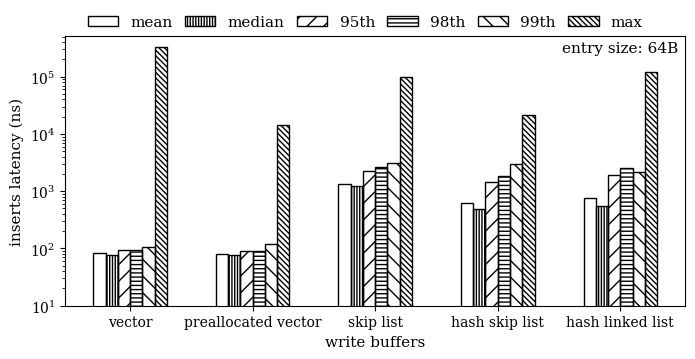

In [245]:
fig, ax = plt.subplots(figsize=(8, 3.5))

start = 0
end = inserts

width = 0.1

x1 = [x-0.25 for x in range(0, 5)]
x2 = [x-0.15 for x in range(0, 5)]
x3 = [x-0.05 for x in range(0, 5)]
# x3 = [x for x in range(0, 5)]
x4 = [x+0.05 for x in range(0, 5)]
x5 = [x+0.15 for x in range(0, 5)]
x6 = [x+0.25 for x in range(0, 5)]

# plot vector
ax.bar(
    x1,
    [
        vecdf["TimeTaken"][start:end+1].mean(),
        vecdf_preallocated["TimeTaken"][start:end+1].mean(),
        skipdf["TimeTaken"][start:end+1].mean(),
        hash_skipdf["TimeTaken"][start:end+1].mean(),
        hash_linkdf["TimeTaken"][start:end+1].mean(),
    ],
    width,
    label="mean",
    **get_properties("mean"),
)

# plot pre-allocated vector
ax.bar(
    x2,
    [
        vecdf["TimeTaken"][start:end+1].median(),
        vecdf_preallocated["TimeTaken"][start:end+1].median(),
        skipdf["TimeTaken"][start:end+1].median(),
        hash_skipdf["TimeTaken"][start:end+1].median(),
        hash_linkdf["TimeTaken"][start:end+1].median(),
    ],
    width,
    label="median",
    **get_properties("median"),
)

# plot skip list
ax.bar(
    x3,
    [
        vecdf["TimeTaken"][start:end+1].quantile(0.95),
        vecdf_preallocated["TimeTaken"][start:end+1].quantile(0.95),
        skipdf["TimeTaken"][start:end+1].quantile(0.95),
        hash_skipdf["TimeTaken"][start:end+1].quantile(0.95),
        hash_linkdf["TimeTaken"][start:end+1].quantile(0.95),
    ],
    width,
    label="95th",
    **get_properties("95th"),
)

# plot hash skip list
ax.bar(
    x4,
    [
        vecdf["TimeTaken"][start:end+1].quantile(0.98),
        vecdf_preallocated["TimeTaken"][start:end+1].quantile(0.98),
        skipdf["TimeTaken"][start:end+1].quantile(0.98),
        hash_skipdf["TimeTaken"][start:end+1].quantile(0.98),
        hash_linkdf["TimeTaken"][start:end+1].quantile(0.98),
    ],
    width,
    label="98th",  #f"hash skip list X {prefixlen} H {bucket_count//1000}K",
    **get_properties("98th"),
)

# plot hash link list
ax.bar(
    x5,
    [
        vecdf["TimeTaken"][start:end+1].quantile(0.99),
        vecdf_preallocated["TimeTaken"][start:end+1].quantile(0.99),
        hash_linkdf["TimeTaken"][start:end+1].quantile(0.99),
        skipdf["TimeTaken"][start:end+1].quantile(0.99),
        hash_skipdf["TimeTaken"][start:end+1].quantile(0.99),
    ],
    width,
    label="99th", # f"hash linked list X {prefixlen} H {bucket_count//1000}K",
    **get_properties("99th"),
)

ax.bar(
    x6,
    [
        vecdf["TimeTaken"][start:end+1].max(),
        vecdf_preallocated["TimeTaken"][start:end+1].max(),
        skipdf["TimeTaken"][start:end+1].max(),
        hash_skipdf["TimeTaken"][start:end+1].max(),
        hash_linkdf["TimeTaken"][start:end+1].max(),
    ],
    width,
    label="max",
    **get_properties("max"),
)

ax.set_yscale("log")
ax.set_ylim(bottom=10**1)


ax.set_xticks([x for x in range(0, 5)])
ax.set_xticklabels(
    [
        "vector",
        "preallocated vector",
        "skip list",
        "hash skip list",
        "hash linked list",
    ]
)

ax.set_ylabel("inserts latency (ns)", fontsize=11)
ax.set_xlabel("write buffers", fontsize=11)

fig.legend(
    loc="center",
    bbox_to_anchor=(0.5, 0.92),
    ncol=6,
    fontsize=11,
    frameon=False,
    columnspacing=0.8,
)


# ax.grid(axis="y", linestyle="--", alpha=0.3)
# ax.text(
#     4,
#     3.1e5,
#     f"entry size: {entry_size}B",
#     fontsize=11,
#     verticalalignment="center",
#     horizontalalignment="center",
#     color="black",
# )

plt.savefig("inserts-latency.eps", format="eps", bbox_inches="tight", dpi=1200)